In [1]:
import re
import os 
import sys 

import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io

from pathlib import Path
from tqdm.notebook import trange, tqdm
from joblib import Parallel, delayed
from skimage import exposure
import h5py
import pandas as pd
import scanpy as sc
import anndata as ad
import squidpy as sq
sc.settings.verbosity = 3

from matplotlib.pyplot import rc_context
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from functools import reduce
from matplotlib import cm, colors
import scanorama
import seaborn as sns 


In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / 'data' 

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

# Load adata

In [4]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [5]:
adata_path = data_dir / 'metadata' / f"combined_LDA_05_24.h5ad"
adata = sc.read_h5ad(adata_path)

In [6]:
adata

AnnData object with n_obs × n_vars = 1955450 × 10
    obs: 'ROI', 'Cell', 'Dataset', 'leiden', 'clusters', 'X_centroid', 'Y_centroid', 'CN'
    uns: 'CN_colors', 'Dataset_colors', 'clusters_colors', 'dendrogram_CN', 'dendrogram_clusters', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'neighbors', 'spatial_lda', 'spatial_lda_probability'
    obsm: 'X_scanorama', 'X_tsne', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

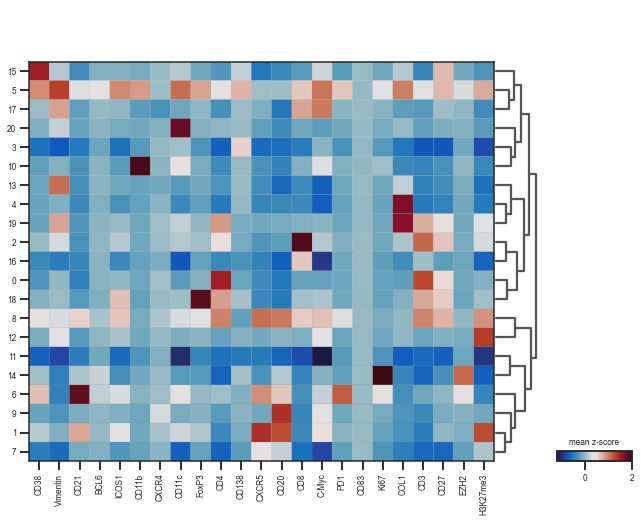

In [7]:
sns.set('talk', font_scale=1.5)
sns.set_style('ticks')

sc.pl.matrixplot(adata, adata.raw.var_names.tolist(), 'clusters', dendrogram=True,
                 colorbar_title='mean z-score', cmap=heatmap_cmp, vmax=2)


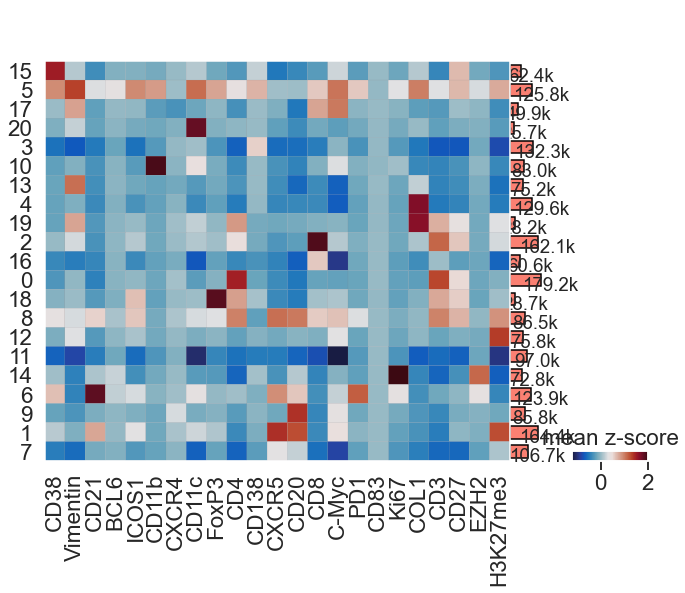

In [8]:
sns.set('talk', font_scale=1.5)

p = sc.pl.matrixplot(adata, adata.raw.var_names.tolist(), 'clusters', dendrogram=True,
                 colorbar_title='mean z-score', cmap=heatmap_cmp, vmax=2, return_fig=True)

p.add_totals().show()


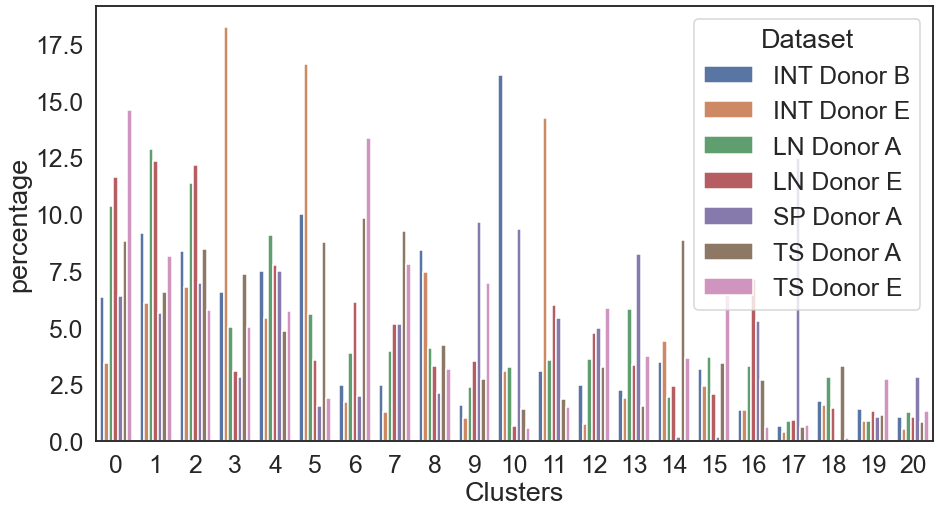

In [9]:
# Get cluster dataframe 
df_test = pd.DataFrame()
df_test['Dataset'] = adata.obs['Dataset'].tolist()
df_test['Clusters'] = adata.obs['clusters'].tolist()

clusters = df_test['Clusters'].unique().tolist()
clusters.sort(key = int)

# Plot distribution
df_test_grouped = df_test.groupby('Dataset')['Clusters'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
with sns.axes_style("white"):
    sns.barplot(data=df_test_grouped, x='Clusters', y='percentage', hue='Dataset', order=[i for i in clusters])
    plt.gcf().set_size_inches(15, 8)

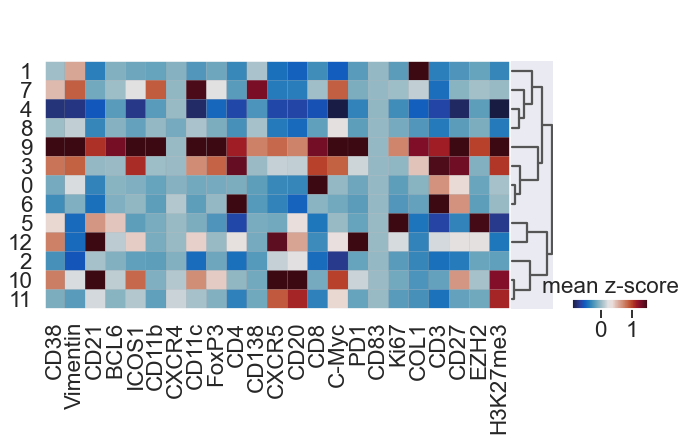

In [10]:
sc.pl.matrixplot(adata, adata.raw.var_names.tolist(), 'CN', dendrogram=True,
                 colorbar_title='mean z-score', cmap=heatmap_cmp, vmax=1.5)

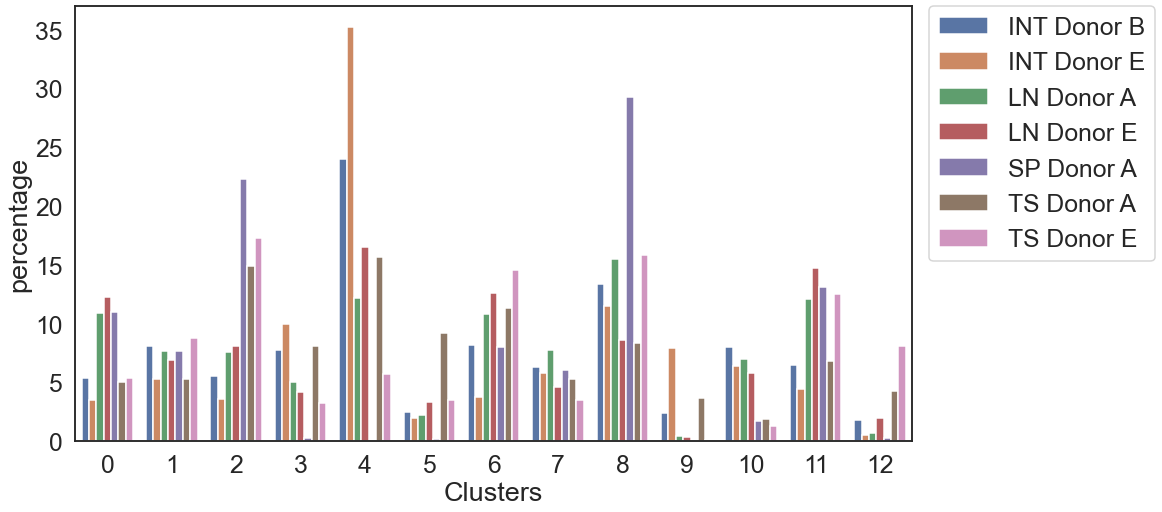

In [11]:
# Get cluster dataframe 
df_test = pd.DataFrame()
df_test['Dataset'] = adata.obs['Dataset'].tolist()
df_test['Clusters'] = adata.obs['CN'].tolist()

clusters = df_test['Clusters'].unique().tolist()
clusters.sort(key = int)

# Plot distribution
df_test_grouped = df_test.groupby('Dataset')['Clusters'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
with sns.axes_style("white"):
    sns.barplot(data=df_test_grouped, x='Clusters', y='percentage', hue='Dataset', order=[i for i in clusters])
    plt.gcf().set_size_inches(15, 8)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


In [12]:
import matplotlib 

var = 'clusters'

cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}




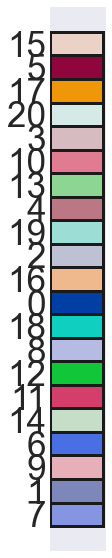

In [13]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,10))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


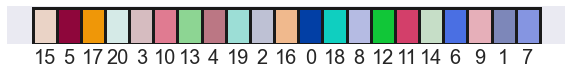

In [14]:
# legend
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

fig, ax = plt.subplots(figsize=(10,0.7))
ax.bar(x=cluster_label_order, 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.xticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=20)
_ = plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.grid(False)


# Generate clustered cell mask

In [15]:
import matplotlib 
from PIL import Image

def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1],3), dtype=np.uint8)

    # for i, cells in tqdm(label2cell.items(), total=len(label2cell), leave=False):
    for i, cells in label2cell.items():
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]
    return img


def get_img_size(roi_dict, size=1000):
    row_max = 0
    col_max = 0
    for k, v in roi_dict.items():
        row_max = max(row_max, v[0])
        col_max = max(col_max, v[1])
    return row_max + size, col_max + size

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


In [16]:
donor = f"combined_04_27"

all_donor = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
    "SP Donor A"
]


In [17]:
if "combined" in donor:
    masks = {}
    for d in all_donor:
        masks[d] = get_masks(data_dir / "masks" / d)
else:
    masks = get_masks(data_dir / "masks" / donor)

In [18]:
# Format row, col
arrangement = {
    "LN Donor A": {
        1: [0, 1000],
        2: [0, 2000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [1000, 2000],
        6: [1000, 3000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [2000, 3000],
        11: [3000, 0],
        12: [3000, 1000],
        13: [3000, 2000],
        14: [3000, 3000],
        15: [4000, 1000],
        16: [4000, 2000],
    },
    "LN Donor E": {
        1: [1000, 0],
        2: [1000, 1000],
        3: [1000, 2000],
        4: [1000, 3000],
        5: [1000, 4000],
        6: [1000, 5000],
        7: [1000, 6000],
        8: [1000, 7000],
        9: [1000, 8000],
        10: [0, 0],
        11: [0, 1000],
        12: [0, 2000],
        13: [0, 3000],
        14: [0, 4000],
    },
    "INT Donor B": {
        1: [0, 0],
        2: [0, 1000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [2000, 0],
        6: [2000, 1000],
        7: [2000, 2000],
        8: [2000, 3000],
        9: [3000, 0],
        10: [3000, 1000],
        11: [3000, 2000],
        12: [3000, 3000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [4000, 3000],
        # 17: [5000, 0],
        # 18: [5000, 1000],
        # 19: [5000, 2000],
        # 20: [5000, 3000],
    },
    "INT Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        # 5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 3000],
        12: [2000, 4000],
        13: [3000, 3000],
        14: [3000, 4000],
        15: [4000, 3000],
        16: [4000, 4000],
    },
    "TS Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [0, 5000],
        7: [0, 6000],
        8: [1000, 0],
        9: [1000, 1000],
        10: [1000, 2000],
        11: [1000, 3000],
        12: [1000, 4000],
        13: [1000, 5000],
        14: [1000, 6000],
    },
    "TS Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [1000, 0],
        5: [1000, 1000],
        6: [1000, 2000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [3000, 0],
        11: [3000, 1000],
        12: [3000, 2000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [5000, 0],
        17: [5000, 1000],
        18: [5000, 2000],
    },
    "SP Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 0],
        12: [2000, 1000],
        13: [2000, 2000],
        14: [2000, 3000],
        15: [2000, 4000],
        16: [3000, 0],
        17: [3000, 1000],
        18: [3000, 2000],
        19: [3000, 3000],
        20: [3000, 4000],
    },
}

### Cell cluster cell mask plot

In [19]:
colors = adata.uns["clusters_colors"]
labels = adata.obs.clusters.cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

In [20]:
size = 1000

labels = [ '5', '3', '11', '12', '9', '7']
for d in adata.obs.Dataset.unique():
    adata_donor = adata[adata.obs.Dataset == d, :]

    # Create combined images
    y_max, x_max = get_img_size(arrangement[d])
    img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[d].keys():
            continue

        # Get dataset
        adata_subset = adata_donor[adata_donor.obs.ROI == i, :]

        # Get mask
        mask = masks[d][str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for l in labels:
            cell_id = adata_subset[adata_subset.obs.clusters == l].obs.Cell.to_list()
            label2cell[l] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[d][i][0] - 1)
        x = max(0, arrangement[d][i][1] - 1)
        img_combined[y : y + size, x : x + size] = img

    save_path = p_dir / "figures" / "CN" / f"Cluster_subset{d}.png"
    img_combined = Image.fromarray(img_combined)
    img_combined.save(save_path)


### CN cell mask plot

In [21]:
colors = adata.uns["CN_colors"]
labels = adata.obs.CN.cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

In [22]:
# size = 1000

# for d in adata.obs.Dataset.unique():
#     adata_donor = adata[adata.obs.Dataset == d, :]

#     # Create combined images
#     y_max, x_max = get_img_size(arrangement[d])
#     img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

#     for i in adata_donor.obs.ROI.unique():
#         if i not in arrangement[d].keys():
#             continue

#         # Get dataset
#         adata_subset = adata_donor[adata_donor.obs.ROI == i, :]

#         # Get mask
#         mask = masks[d][str(int(i))]

#         # Get label2cell dict
#         label2cell = {}
#         for l in labels:
#             cell_id = adata_subset[adata_subset.obs.CN == l].obs.Cell.to_list()
#             label2cell[l] = cell_id

#         img = create_clustered_cell(mask, label2cell, colors_rgb)

#         # Insert to combine image
#         y = max(0, arrangement[d][i][0] - 1)
#         x = max(0, arrangement[d][i][1] - 1)
#         img_combined[y : y + size, x : x + size] = img

#     save_path = p_dir / "figures" / "CN" / f"LDA_{d}.png"
#     img_combined = Image.fromarray(img_combined)
#     img_combined.save(save_path)


In [23]:
# for d in all_donor:
#     adata_subset = adata[adata.obs.Dataset == d, :]

#     with rc_context({"figure.figsize": (20, 20)}):
#         sc.pl.spatial(
#             adata_subset, color="CN", spot_size=20,
#         )

# Tissue level spatial correlation

## Neighborhood enrichment

In [24]:
# with sns.plotting_context('talk', font_scale=1.2):
#     for d in all_donor:
#         print(d)
#         adata_subset = adata[adata.obs.Dataset == d, :]
#         sq.gr.spatial_neighbors(adata_subset, radius=30, coord_type="generic")
#         sq.gr.nhood_enrichment(adata_subset, cluster_key="CN")
#         sq.pl.nhood_enrichment(adata_subset, cluster_key="CN", method="ward", cmap='bwr')

#         sq.gr.interaction_matrix(adata_subset, cluster_key="CN")
#         sq.pl.interaction_matrix(adata_subset, cluster_key="CN", cmap='bwr', )
#         plt.show()

In [25]:
# sq.gr.co_occurrence(adata_subset, cluster_key="CN")

# sq.pl.co_occurrence(
#     adata,
#     cluster_key="CN",
#     clusters=["3"],
#     figsize=(15, 4),
# )

## Custom code

In [81]:
import spatial as sm

In [82]:
# # Var
# spatial_distance = 'spatial_distance'
# imageid = 'Dataset'
# phenotype = 'CN'

# distance_map = adata.uns[spatial_distance]
# pheno_df = pd.DataFrame({'imageid': adata.obs[imageid], 'phenotype': adata.obs[phenotype]}) #image id and phenotype
# data = pd.merge(pheno_df, distance_map, how='outer',left_index=True, right_index=True) # merge with the distance map

KeyError: 'spatial_distance'

Processing Image: LN Donor A
Processing Image: LN Donor E
Processing Image: INT Donor B
Processing Image: INT Donor E
Processing Image: TS Donor A
Processing Image: TS Donor E
Processing Image: SP Donor A


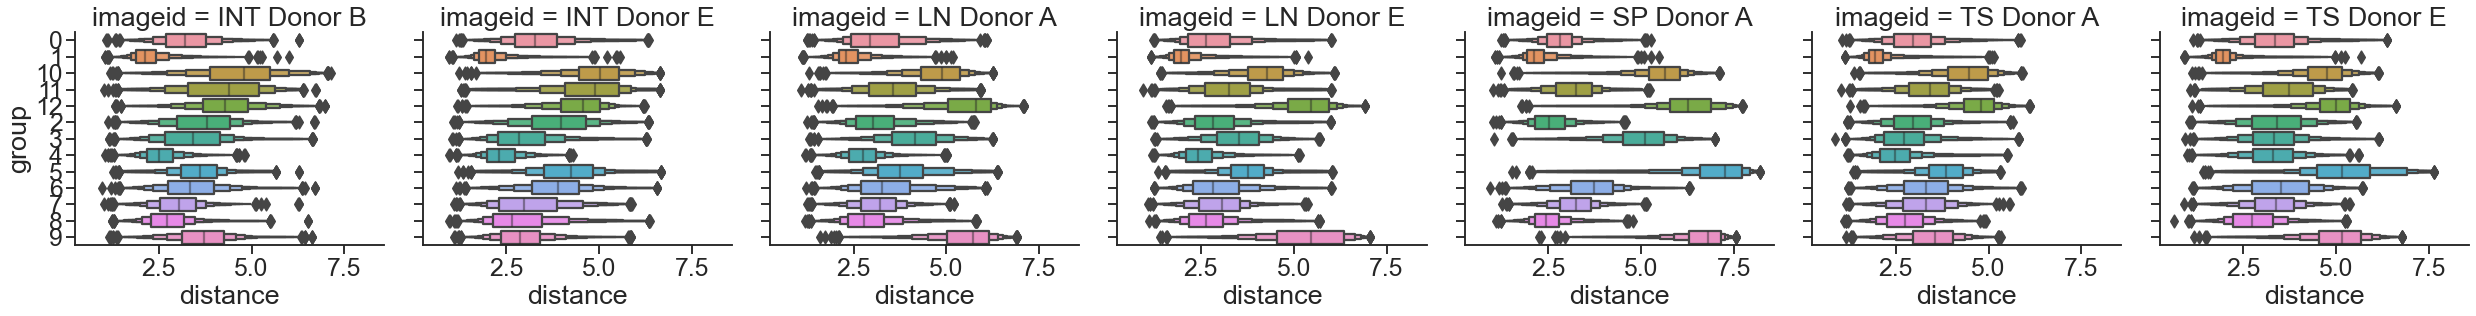

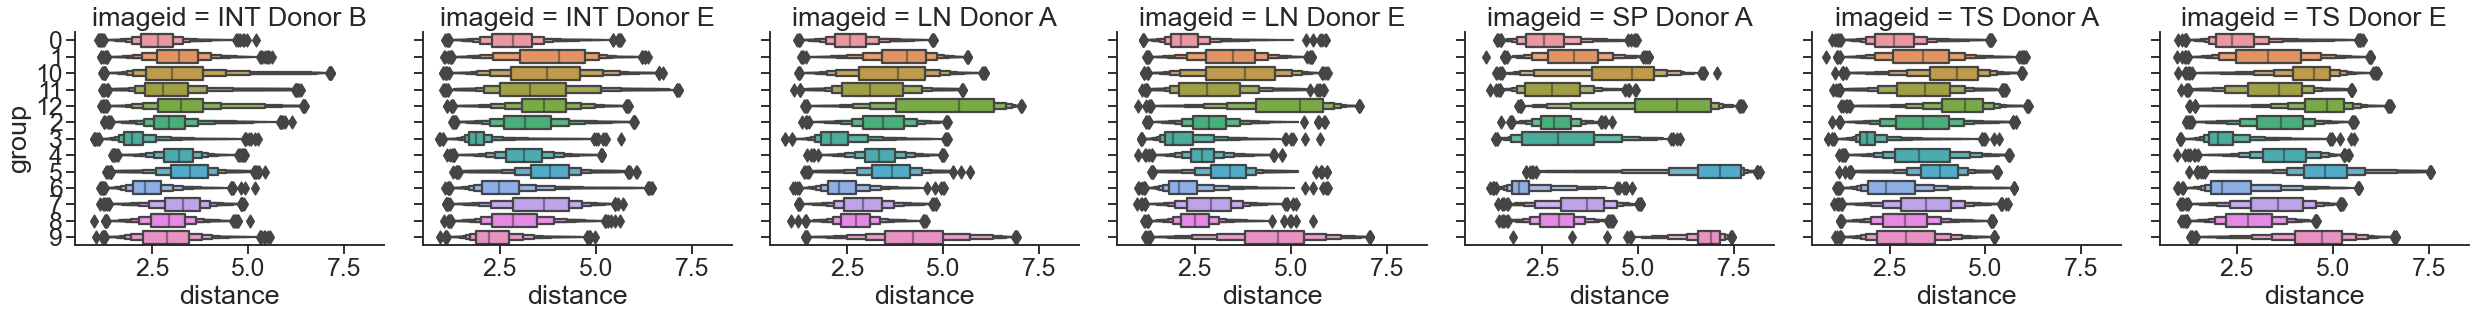

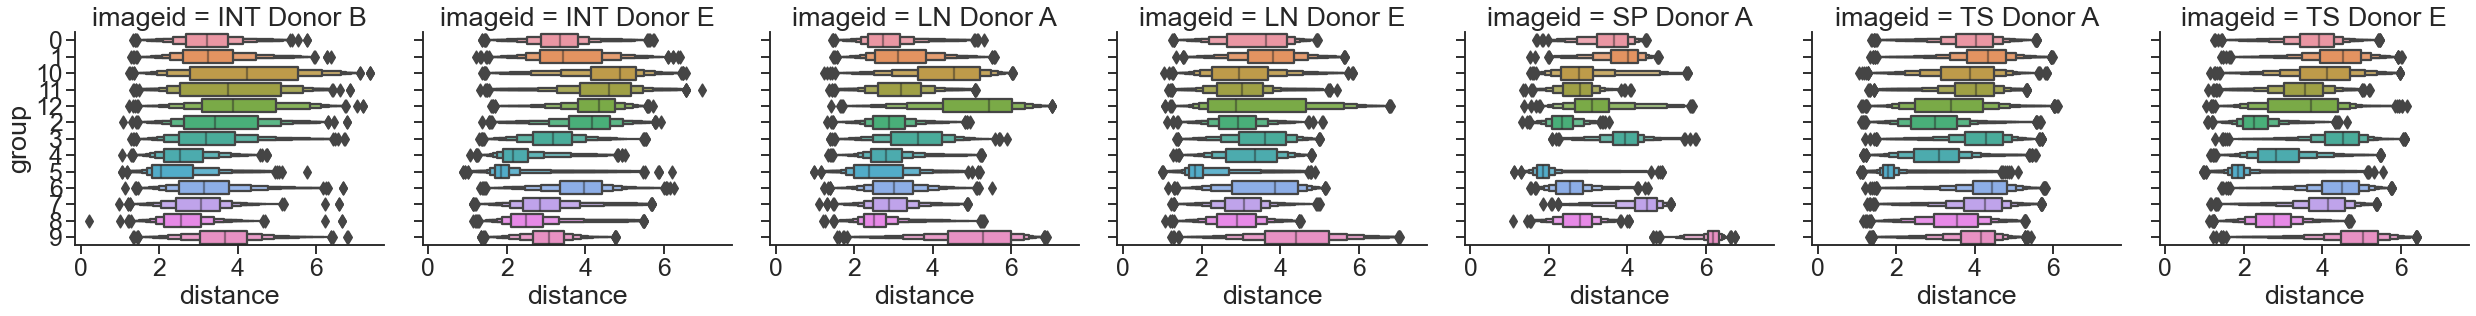

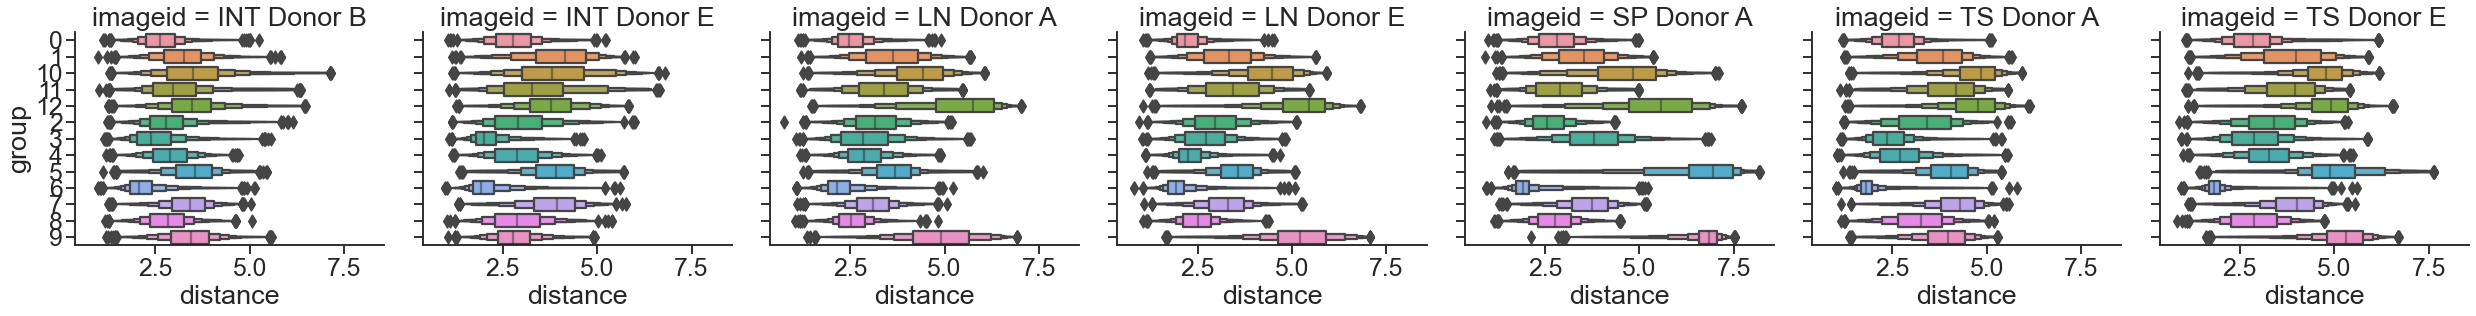

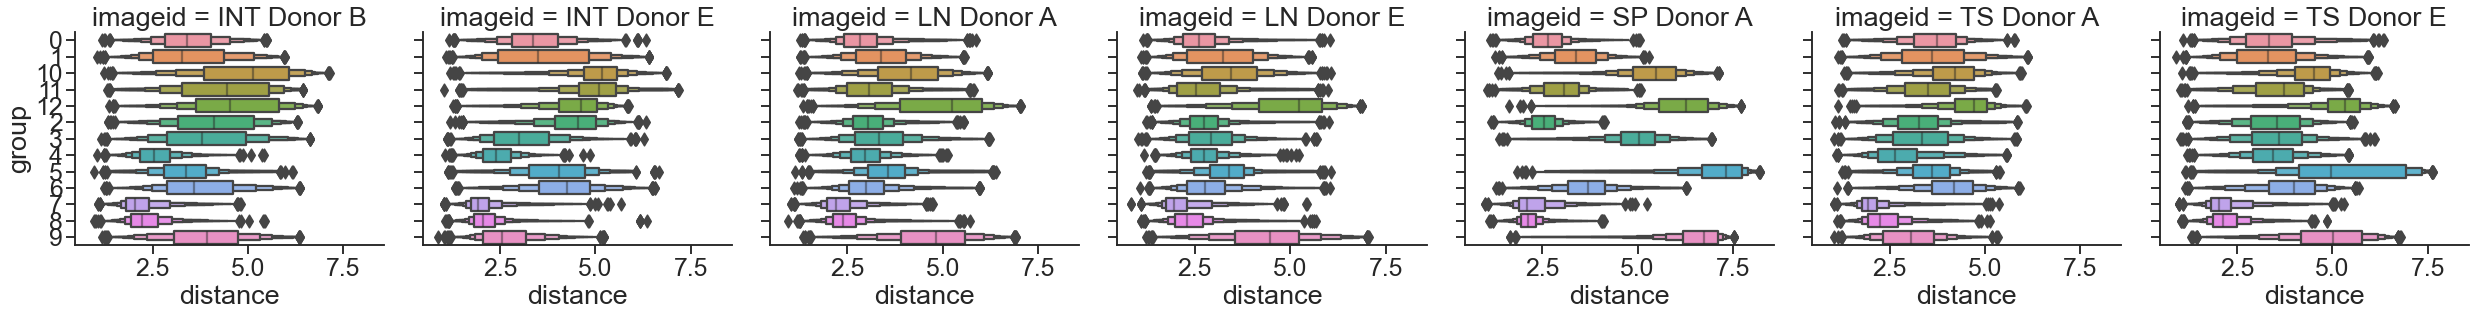

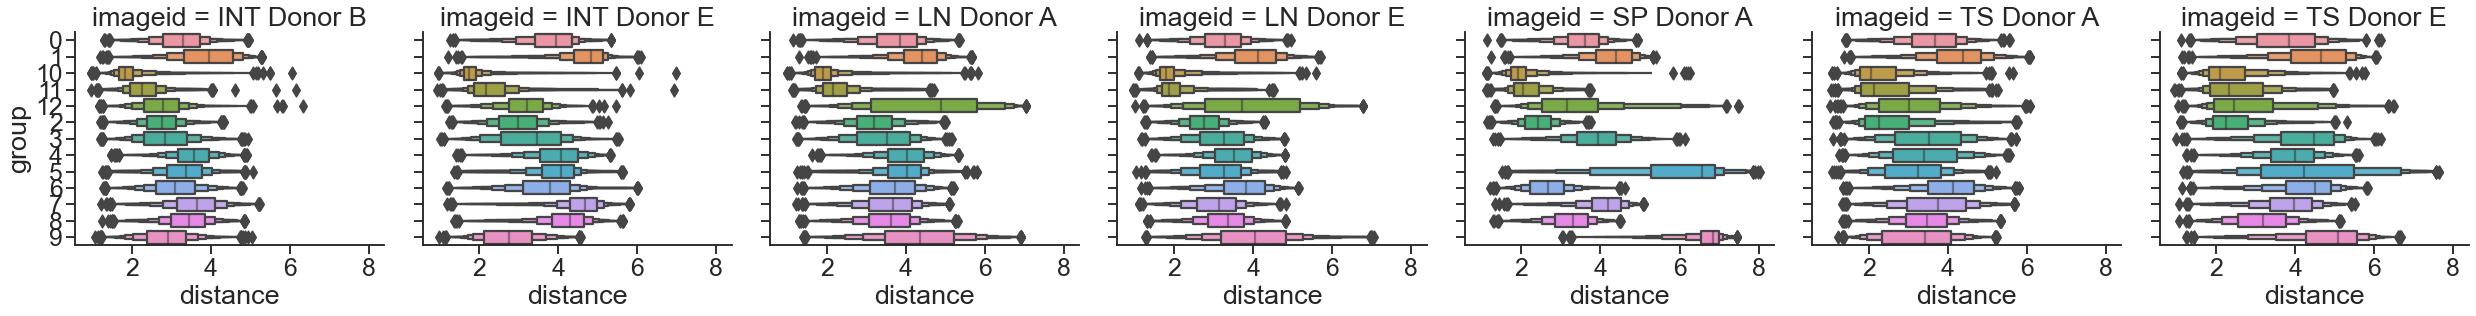

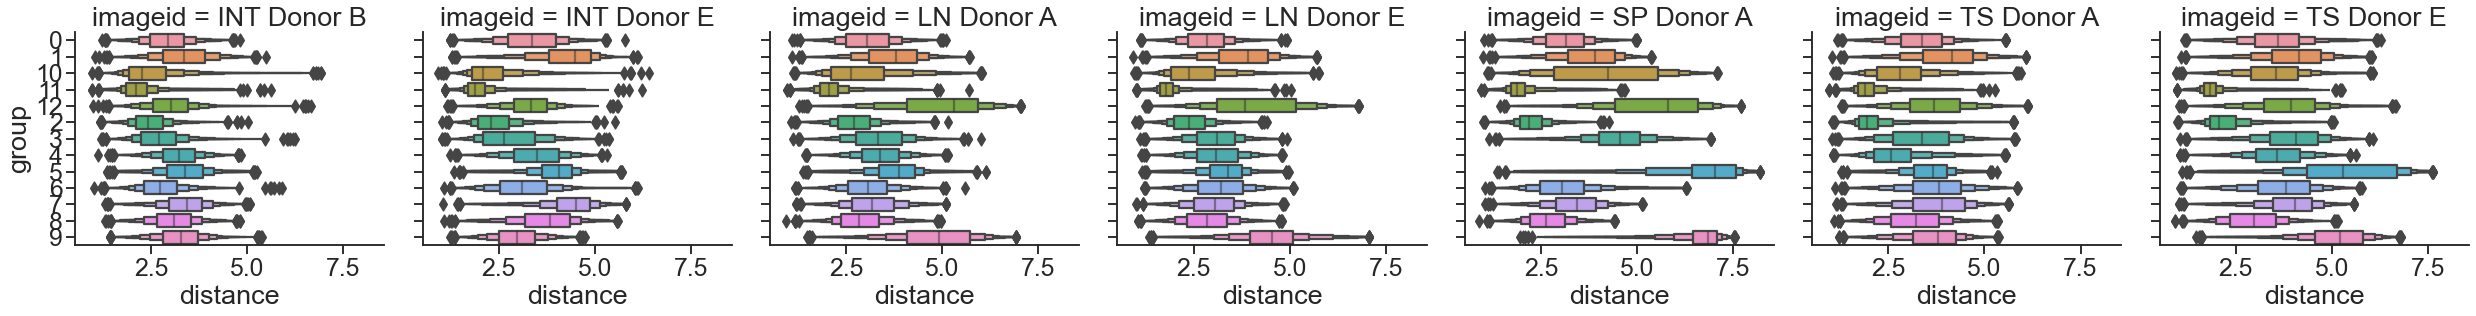

In [84]:
# Plot spatial distance
adata_subset = sm.tl.spatial_distance(adata, x_coordinate='X_centroid', phenotype='CN',
                              y_coordinate='Y_centroid',imageid='Dataset')
sm.pl.spatial_distance(adata_subset, method='numeric', phenotype='CN', 
                   imageid='Dataset', distance_from=1, log=True)
sm.pl.spatial_distance(adata_subset, method='numeric', phenotype='CN', 
                   imageid='Dataset', distance_from=3, log=True)
sm.pl.spatial_distance(adata_subset, method='numeric', phenotype='CN', 
                   imageid='Dataset', distance_from=5, log=True)
sm.pl.spatial_distance(adata_subset, method='numeric', phenotype='CN', 
                   imageid='Dataset', distance_from=6, log=True)
sm.pl.spatial_distance(adata_subset, method='numeric', phenotype='CN', 
                   imageid='Dataset', distance_from=7, log=True)
sm.pl.spatial_distance(adata_subset, method='numeric', phenotype='CN', 
                   imageid='Dataset', distance_from=10, log=True)
sm.pl.spatial_distance(adata_subset, method='numeric', phenotype='CN', 
                   imageid='Dataset', distance_from=11, log=True)

LN Donor A
Processing Image: ['LN Donor A']
Categories (1, object): ['LN Donor A']
Identifying the 15 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Processing Image: LN Donor A


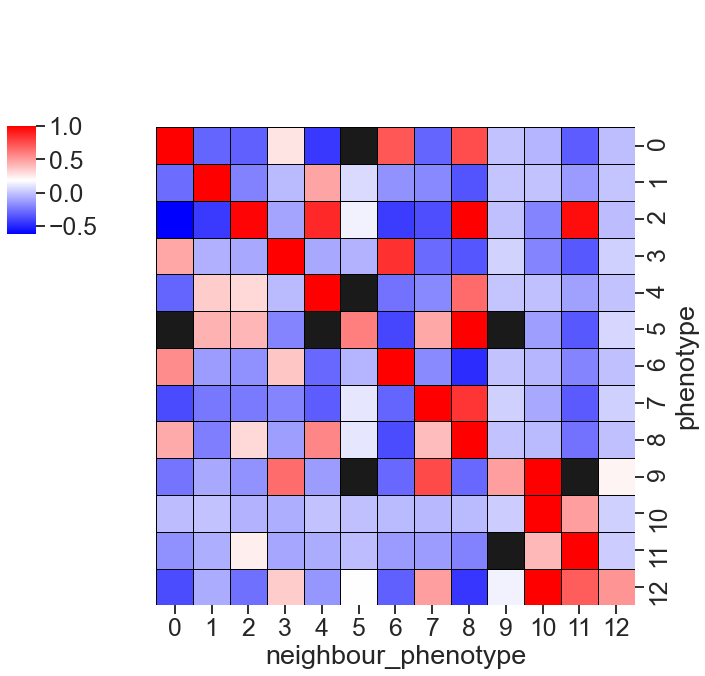

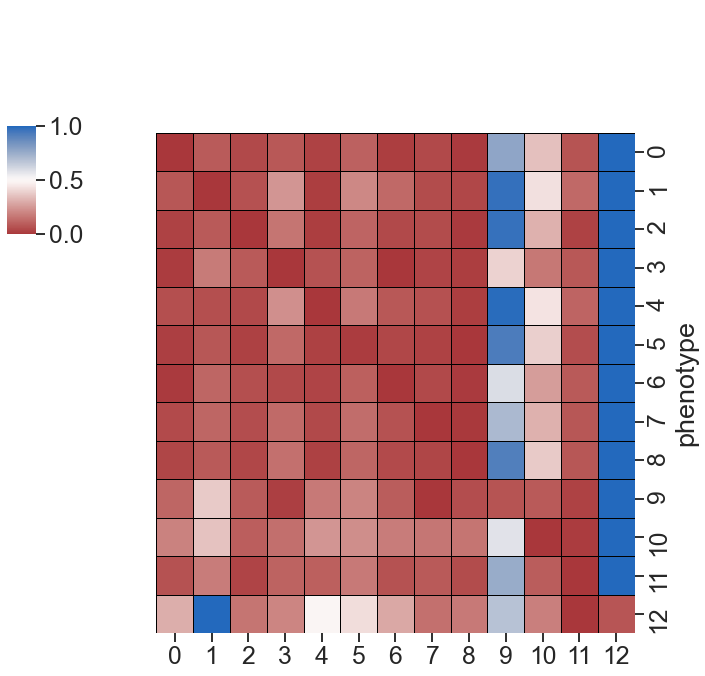

LN Donor E
Processing Image: ['LN Donor E']
Categories (1, object): ['LN Donor E']
Identifying the 15 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Processing Image: LN Donor E


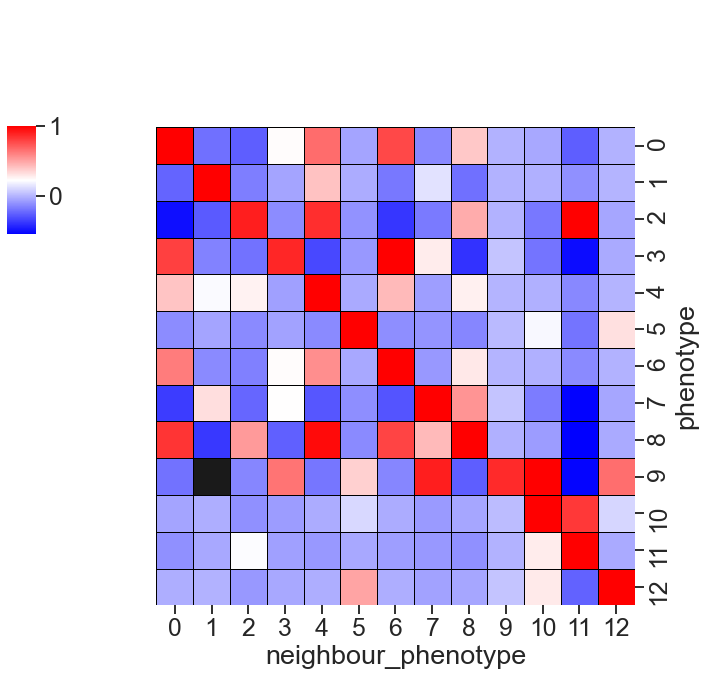

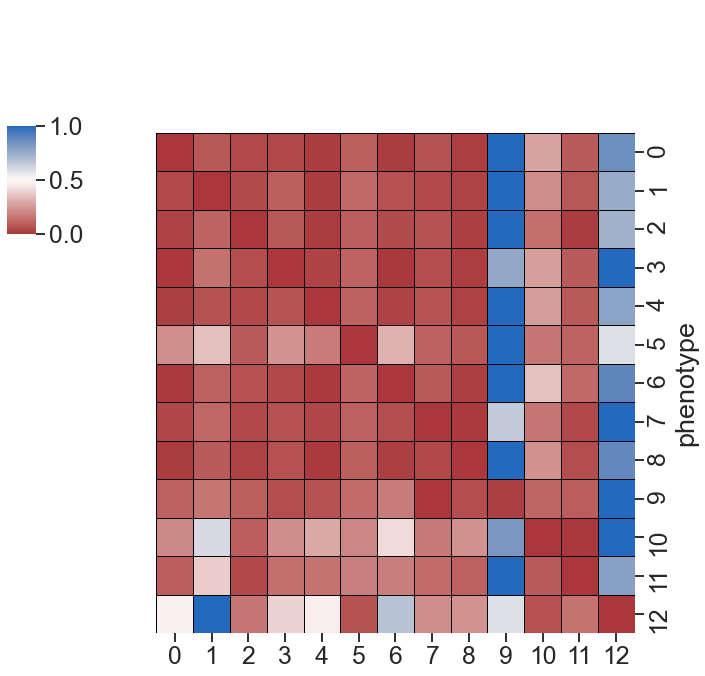

INT Donor B
Processing Image: ['INT Donor B']
Categories (1, object): ['INT Donor B']
Identifying the 15 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Processing Image: INT Donor B


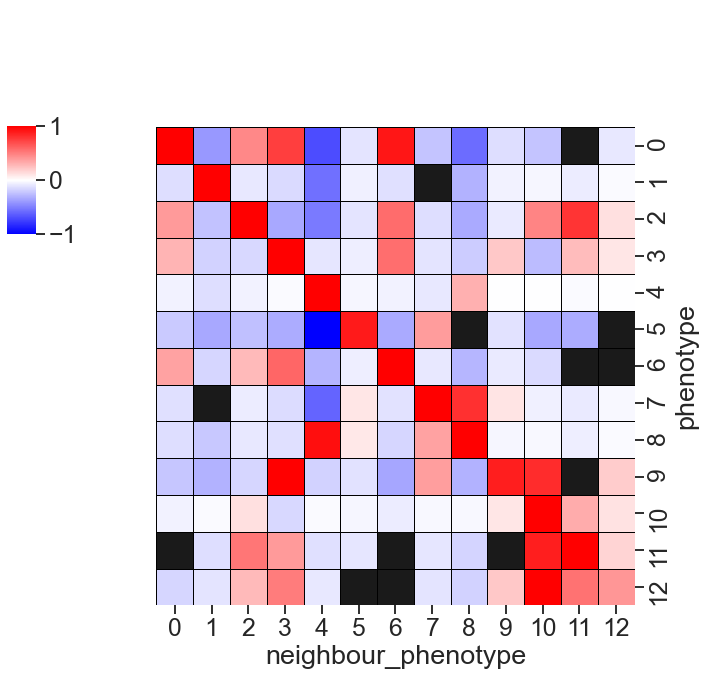

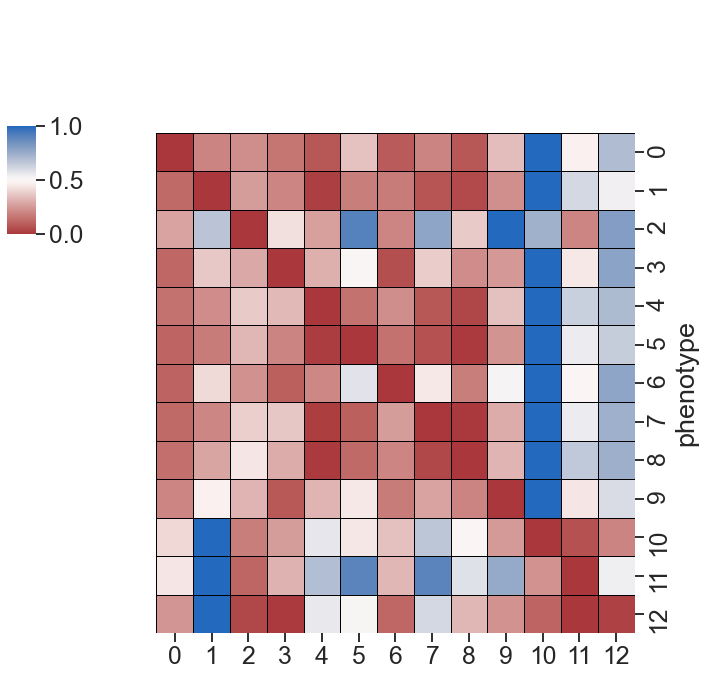

INT Donor E
Processing Image: ['INT Donor E']
Categories (1, object): ['INT Donor E']
Identifying the 15 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Processing Image: INT Donor E


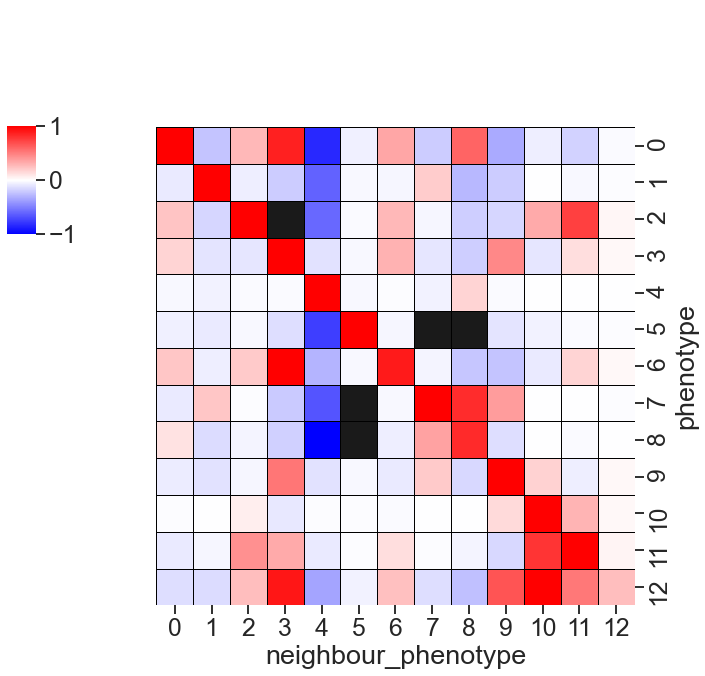

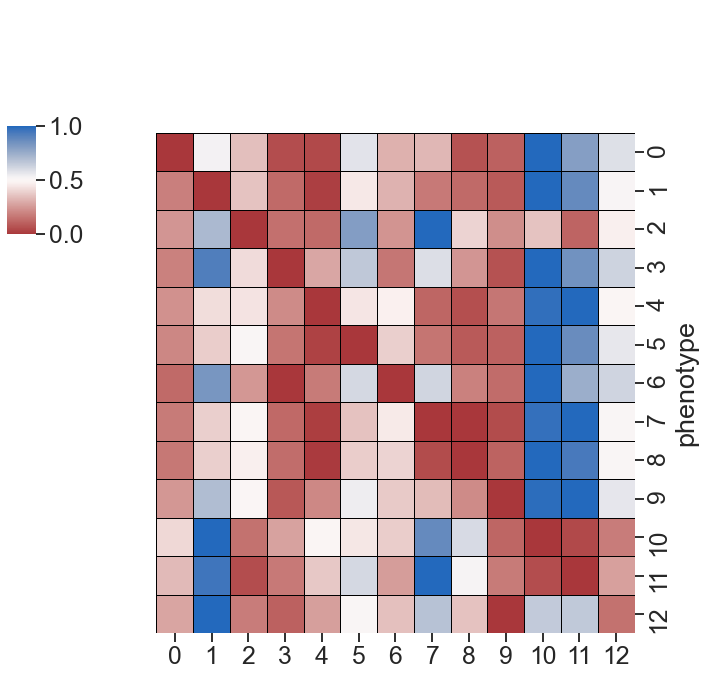

TS Donor A
Processing Image: ['TS Donor A']
Categories (1, object): ['TS Donor A']
Identifying the 15 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Processing Image: TS Donor A


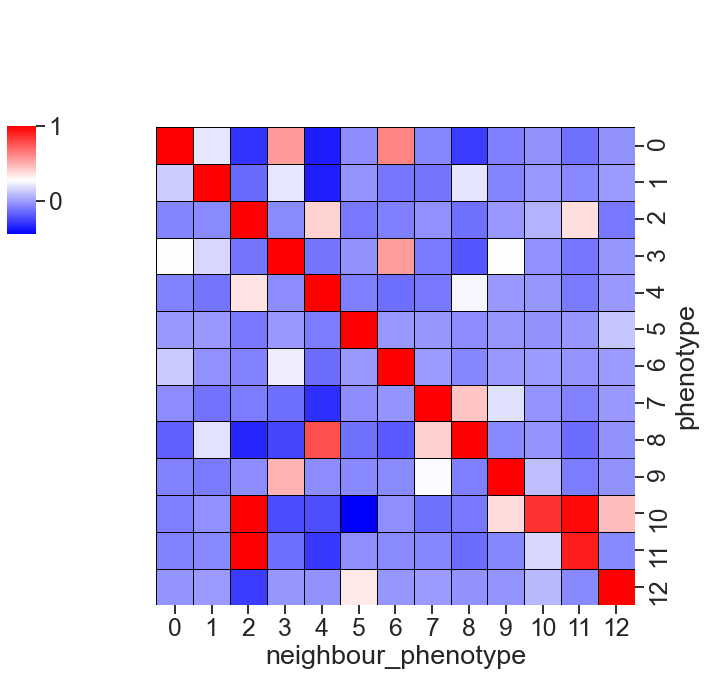

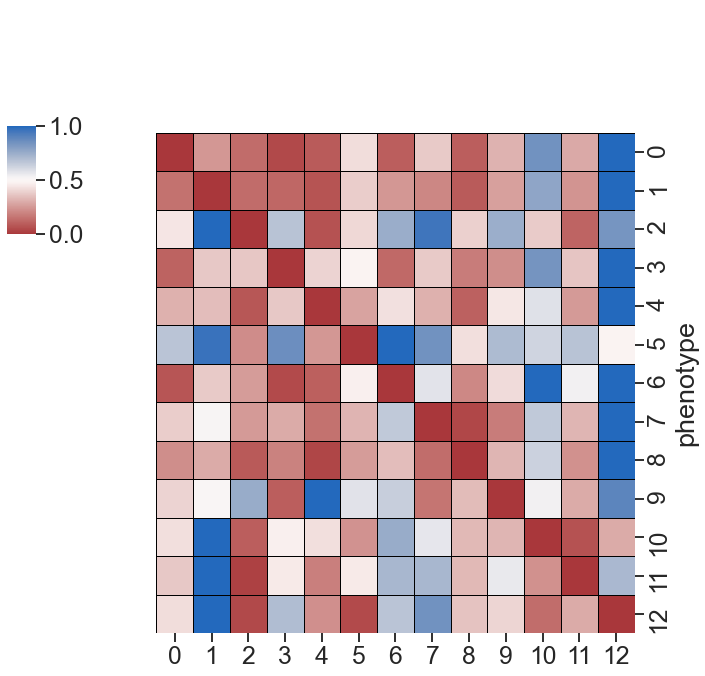

TS Donor E
Processing Image: ['TS Donor E']
Categories (1, object): ['TS Donor E']
Identifying the 15 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Processing Image: TS Donor E


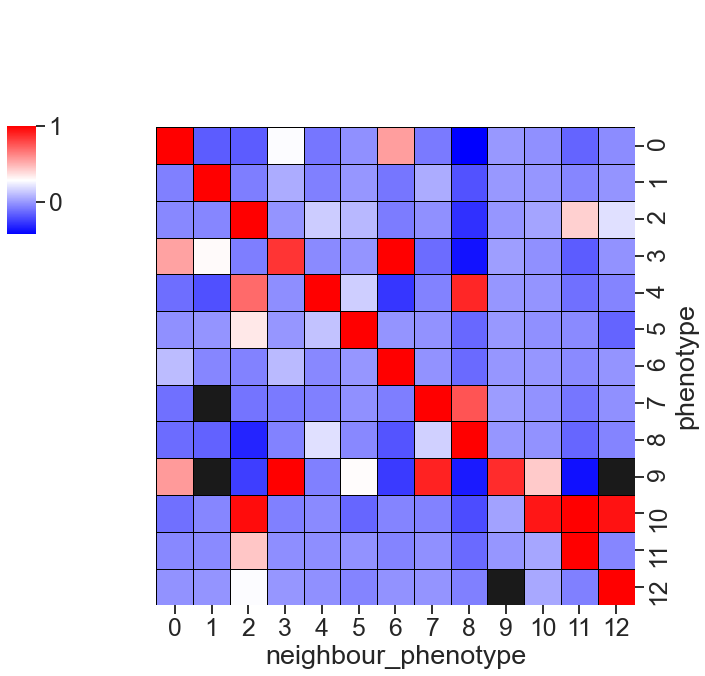

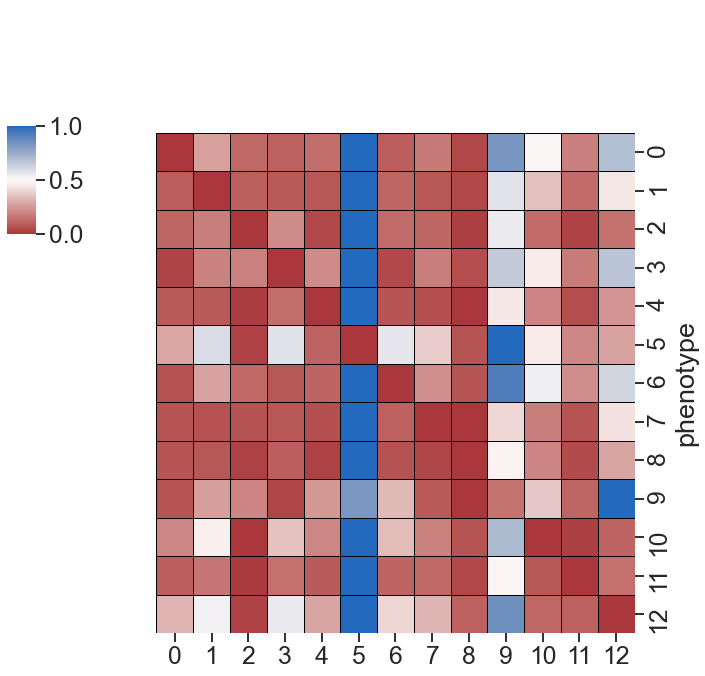

SP Donor A
Processing Image: ['SP Donor A']
Categories (1, object): ['SP Donor A']
Identifying the 15 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Processing Image: SP Donor A


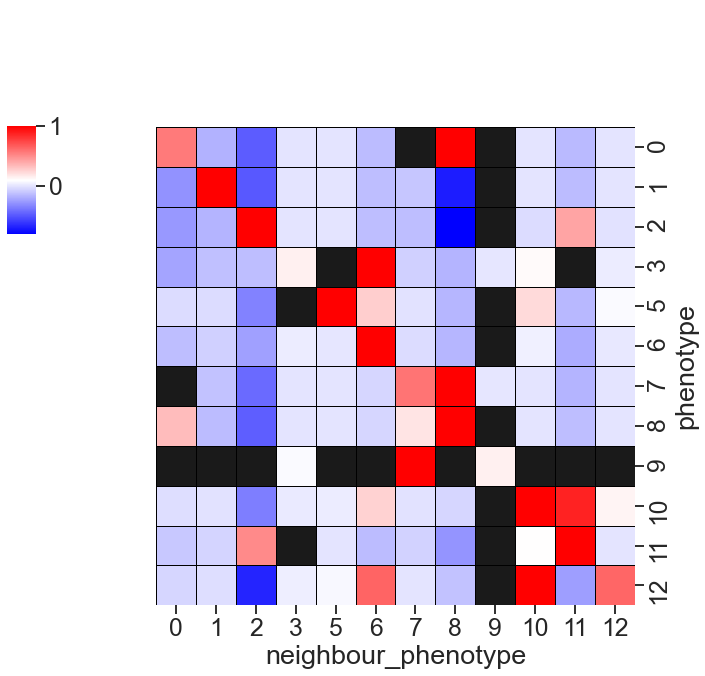

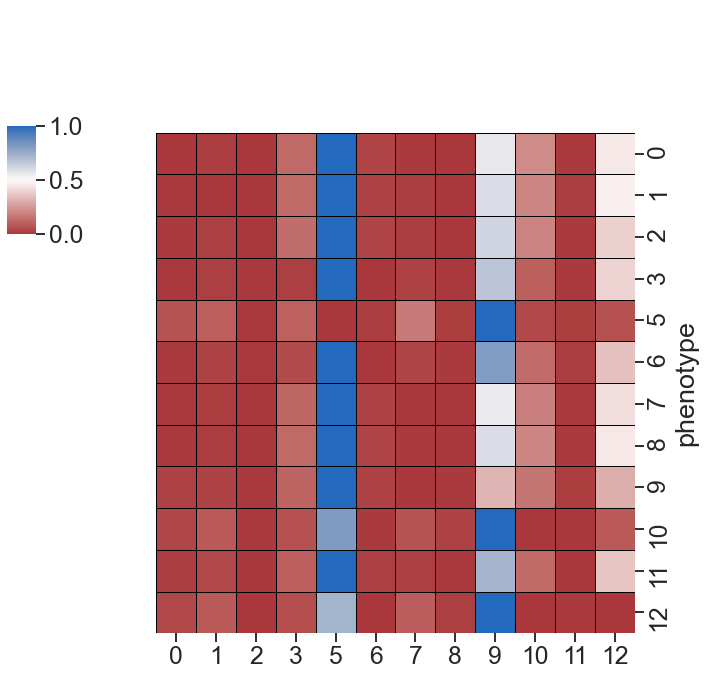

In [96]:
for d in all_donor:
    print(d)
    adata_subset = adata[adata.obs.Dataset == d, :]
    
    # Plot interaction p value 
    adata_subset = sm.tl.spatial_interaction(adata_subset,
                                         method='knn', 
                                         radius=20, 
                                         knn=15,
                                         phenotype='CN',
                                         imageid='Dataset',
                                         x_coordinate='X_centroid',
                                         y_coordinate='Y_centroid')
    sm.pl.spatial_interaction(adata_subset, 
                          summarize_plot=True, 
                          binary_view=False,
                          row_cluster=False, 
                          linewidths=0.75, 
                          linecolor='black',
                          cmap='bwr',
                          p_val=0.0005,
                          nonsig_color='k',
                          cbar_pos=(0.,0.644,0.04, 0.15)    
                         )
    
    # Plot spatial distance
    adata_subset = sm.tl.spatial_distance(adata_subset, x_coordinate='X_centroid', phenotype='CN',
                                  y_coordinate='Y_centroid',imageid='Dataset')
    sm.pl.spatial_distance(adata_subset,  phenotype='CN', imageid='Dataset', 
                       linewidths=0.75, linecolor='black', cbar_pos=(0.,0.644,0.04, 0.15))
    
    plt.show()